In [2]:
import pandas as pd
import numpy as np
import matplotlib

import ipywidgets as widgets
%matplotlib widget

import matplotlib.backends.backend_pdf                  as be_pdf
from skimage              import measure                as skm
from scipy.optimize       import curve_fit              as c_fit
from scipy                import ndimage                as nd
from scipy.ndimage        import center_of_mass         as C_O_M
from mpl_interactions     import ipyplot                as iplt
from mpl_toolkits.mplot3d import Axes3D
from os.path              import isfile, join, isdir
from os import listdir
import copy,scipy,mpld3,astropy,cmath,math,os,json,yapf.yapflib.yapf_api,shutil,h5py,time,gekko
from numpy.linalg         import norm
from mpl_interactions     import hyperslicer
from matplotlib           import pyplot                 as plt
from matplotlib           import rcParams               as rc
from datetime             import datetime

import matplotlib.backends.backend_pdf                  as be_pdf
from skimage              import measure                as skm
from scipy.optimize       import curve_fit              as c_fit
from scipy                import ndimage                as nd
from scipy.ndimage        import center_of_mass         as C_O_M
from mpl_interactions     import ipyplot                as iplt
from mpl_toolkits.mplot3d import Axes3D
from os.path              import isfile, join, isdir
from os import listdir
import seaborn as sns
from scipy.fftpack import fftn, ifftn, fftshift
rc['text.usetex'] = True
sns.set_theme()
rc["figure.autolayout"] = True
rc["figure.dpi"] = 150


import glob
from colour import Color



In [3]:
datadir =r'C:\Users\solene.da-ville\Documents\FemtoTools\Solène\Data\2024-02-05 Nanotrip ZrO2 pillar\CT_C_2024-02-05,09h44m28s\data'

os.chdir(datadir)
os.getcwd()
lst=glob.glob("*.txt")


############# Lecture d'un fichier
name=lst[0]
lstnom=["Index","Phase","Displacement","Time","PosX","PosY","PosZ","RotA","RotB","PiezoX","ForceA","ForceB","Gripper","VoltageA","VoltageB","Temperature","SampleDisplacement"]


In [4]:
data = pd.read_csv(name, delim_whitespace=True, skiprows=3, encoding='unicode_escape', error_bad_lines=False,names=lstnom,low_memory=False);

C:\Users\solene.da-ville\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
del_test_line=[]
with open(name, 'r', encoding='unicode_escape') as file:
    i=0
    for line in file:
       if len(line.split())==28:
           del_test_line.append(i)
       i+=1     
del_test_line=np.array(del_test_line)

In [6]:
data.head()

Index     Phase Displacement         Time          PosX        PosY  \
0       [#]       [#]         [um]          [s]          [um]        [um]   
1  0.000000  1.000000    -0.006572  4383.332667  20266.347000  804.464000   
2  0.000000  1.000000    -0.006437  4383.334667  20266.347000  804.464000   
3  0.000000  1.000000    -0.006780  4383.336667  20266.347000  804.464000   
4  0.000000  1.000000    -0.006735  4383.338667  20266.347000  804.464000   

          PosZ      RotA      RotB     PiezoX    ForceA ForceB   Gripper  \
0         [um]      [m°]      [m°]       [um]      [uN]   [uN]       [V]   
1  -286.088000  0.000000  0.000000  -0.000403  0.118487    NaN  0.000000   
2  -286.088000  0.000000  0.000000  -0.000268  0.138724    NaN  0.000000   
3  -286.088000  0.000000  0.000000  -0.000611  0.116876    NaN  0.000000   
4  -286.088000  0.000000  0.000000  -0.000565  0.071791    NaN  0.000000   

   VoltageA   VoltageB Temperature SampleDisplacement  
0       [V]        [V]        [°C]               [um]  
1  0.000941  -0.006918   28.013102          -0.979643  
2  0.000921  -0.006891   28.013368          -0.979508  
3  0.000944  -0.006923   28.012925          -0.979851  
4  0.000994  -0.006926   28.013226          -0.979806

In [7]:
del_test_line=np.where(data["ForceA"]=='[uN]')[0]
del_test_line=[*del_test_line,*[len(data["ForceA"])+2]] #On ajoute le dernier point +2
len(del_test_line)
# del_test_line= posotion des lignes où les tests commencent + dernier point+2 (necessaire pour le traitement des data)

70

In [8]:
#Extraction raw data

scan_old=0
ForceA=[]
Displacement_raw=[]
Pos_X=[]
for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    ForceA.append( np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1])
    Displacement_raw.append(np.nan_to_num(data["Displacement"][a+1:b-2].values.astype(float))[:-1])
    Pos_X.append(np.nan_to_num(data["PosX"][a+1:b-2].values.astype(float))[:-1])
    scan_old=int(scan+1)
    


In [9]:
#plt.plot((1/21400)*np.array(ForceA[5]),ForceA[5])

In [10]:
#Calibration using the Frame_stiffness value

Frame_stiffness= 23300 #N/m

#Recalibrating

Displacement=[]
scan_old=0

for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    Displacement.append(np.nan_to_num(data["PiezoX"][a+1:b-2].values.astype(float))[:-1]-1/Frame_stiffness*np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1])
    scan_old=int(scan+1)





In [11]:
#Computation of SampleDisplacement (to be improved)

SampleDisplacement=[]
scan_old=0

for scan in range(len(del_test_line)-1):#wanted_test:
    a,b=del_test_line[scan_old],del_test_line[scan+1]
    surface_position=float(data["PiezoX"][a+2])-float(data["SampleDisplacement"][a+2])
    SampleDisplacement.append(np.nan_to_num(data["PiezoX"][a+1:b-2].values.astype(float))[:-1]-1/Frame_stiffness*np.nan_to_num(data["ForceA"][a+1:b-2].values.astype(float))[:-1]-surface_position)
    scan_old=int(scan+1)


In [12]:
#Displacement_cal=[ np.array(Displacement[i])-(1/21400)*np.array(ForceA[i]) for i in range(len(ForceA))]

In [13]:
plt.rcParams.update(plt.rcParamsDefault)

plt.rcParams.update(
    {
        "figure.figsize": (10, 5),
        "figure.facecolor":"w",
        "font.size": 10,
        "axes.grid": True,
        "lines.markersize": 10,
        "lines.linewidth": 2,
    }
)

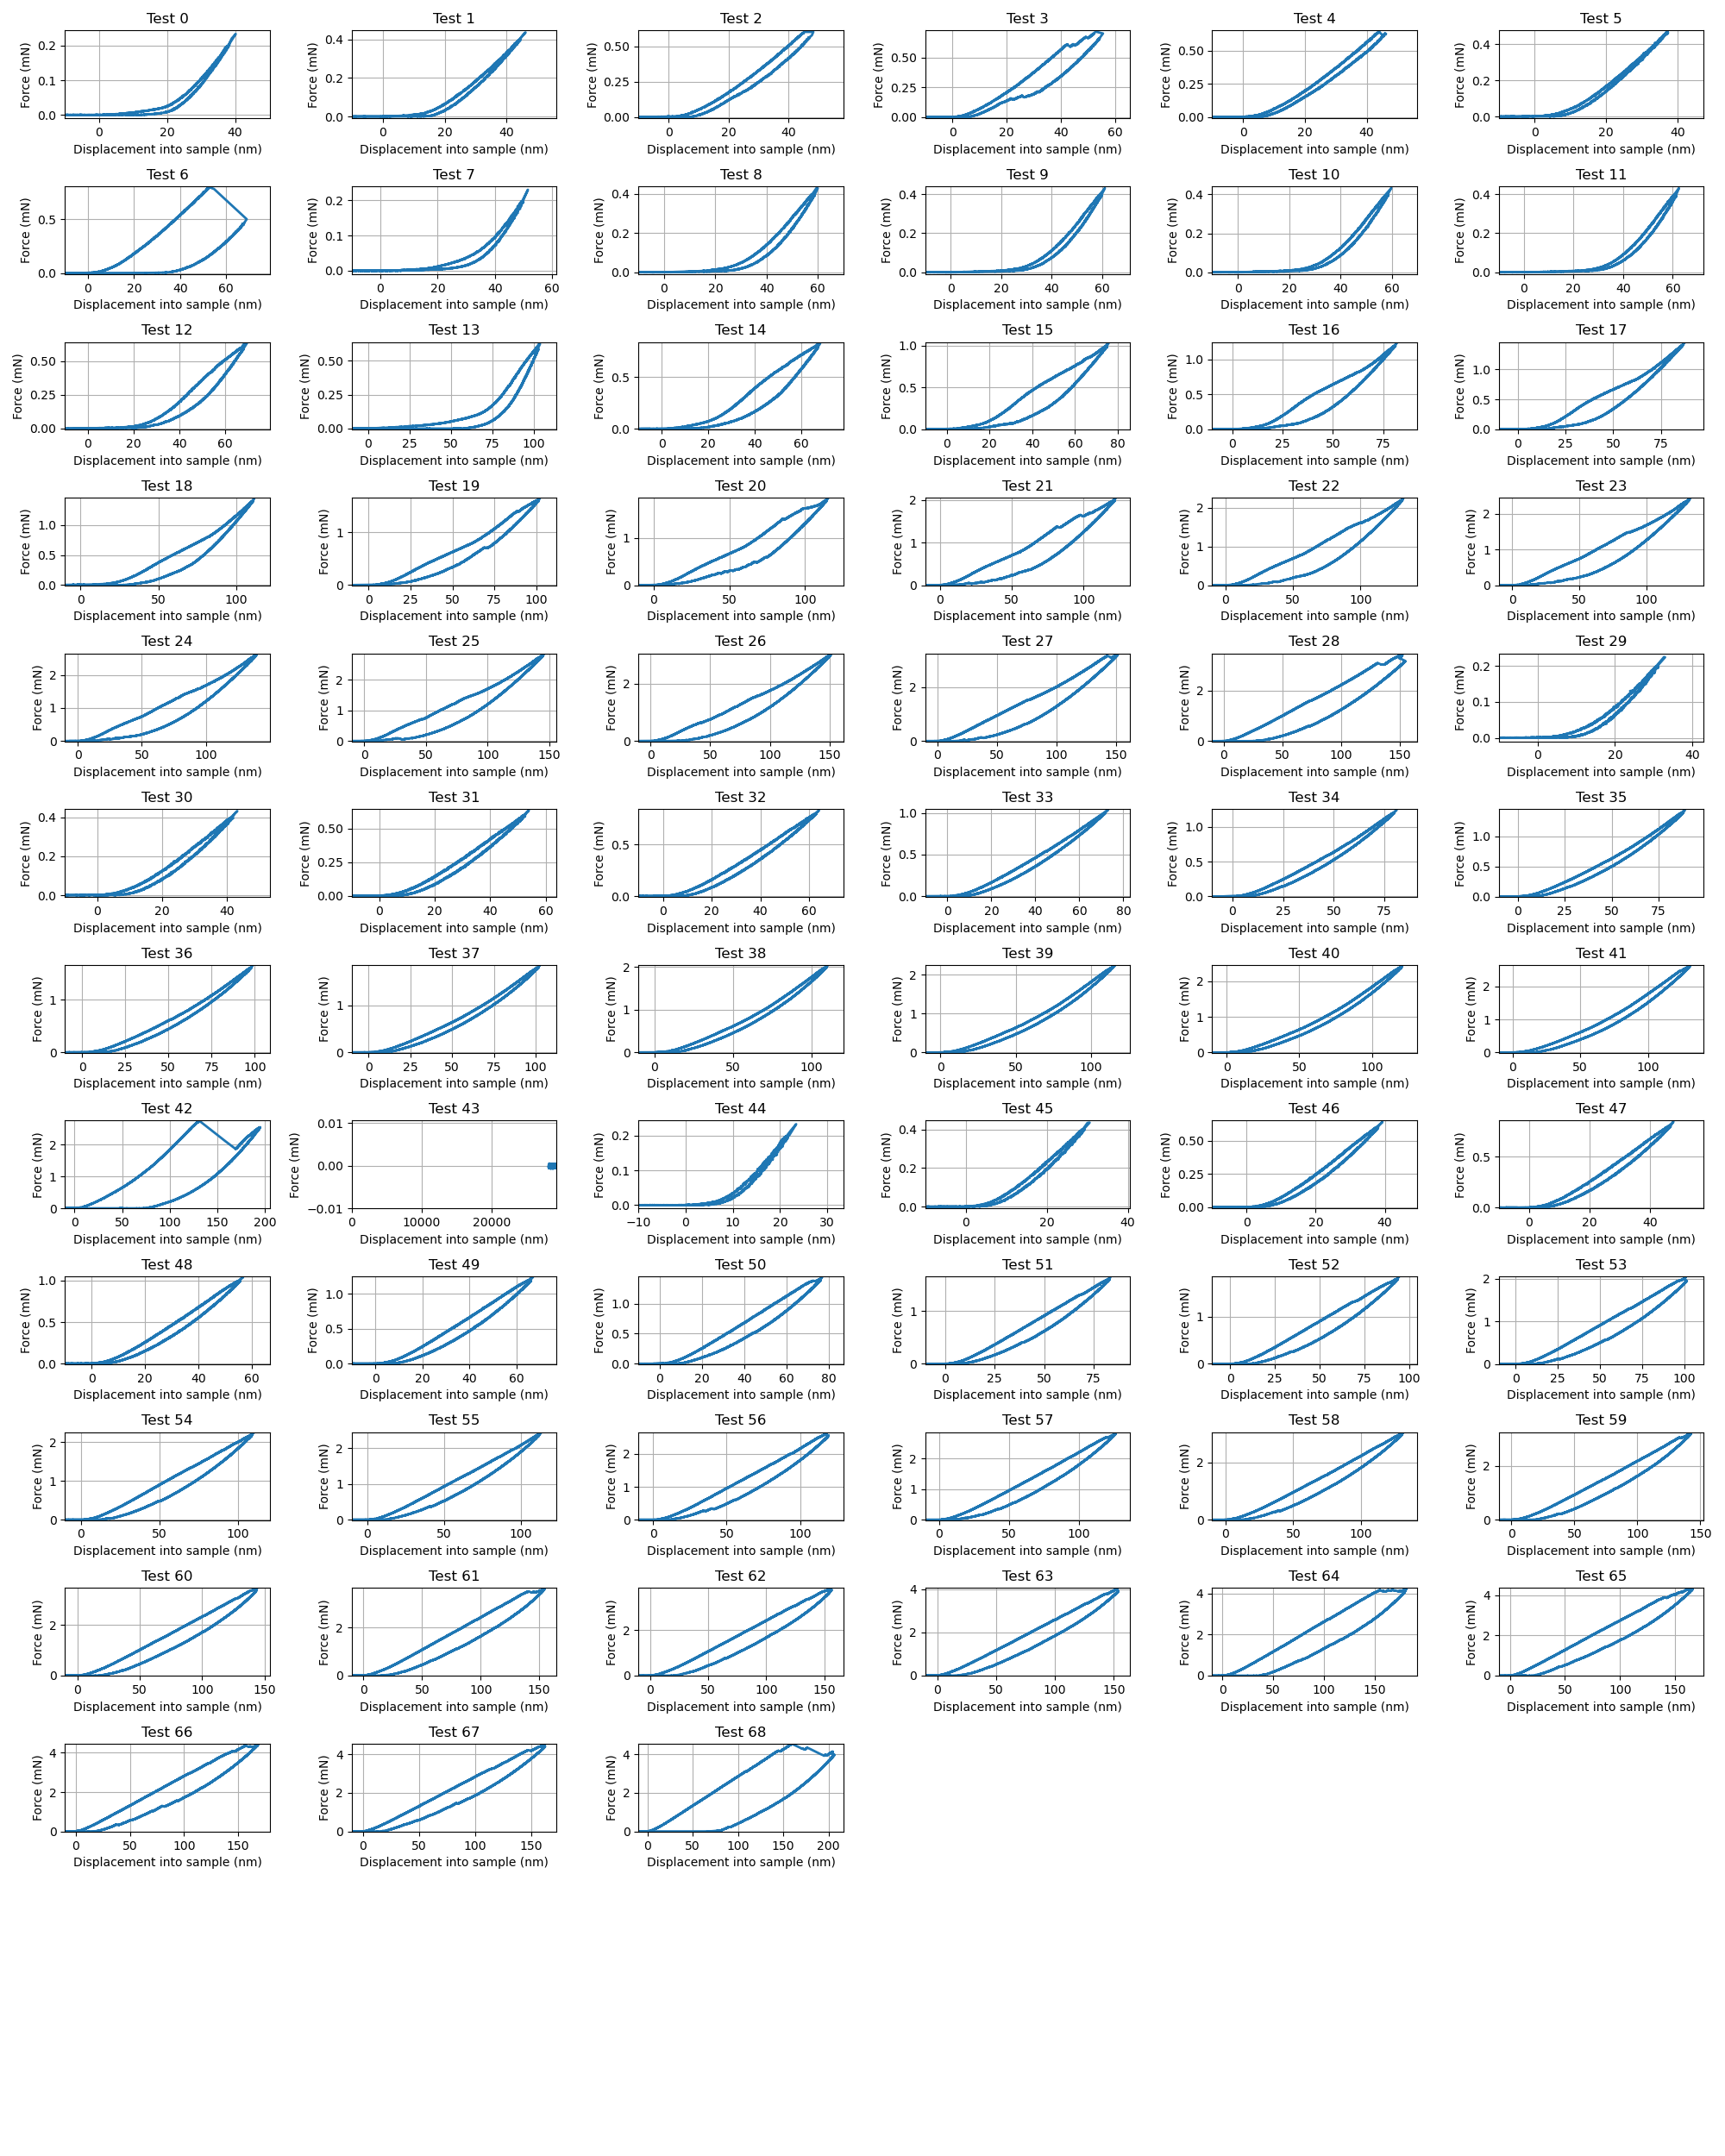

In [14]:
#Draw all sample displacement


scan_old=0
plt.figure(figsize=(20,25))
i=1
for scan in range(len(del_test_line)-1):#wanted_test:
    plt.subplot(len(del_test_line)//5,6,i)
    plt.title("Test "+str(scan))
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan])
    if len(SampleDisplacement[scan])>0:
        plt.xlim(-10,np.array(1000*SampleDisplacement[scan]).max()+10)
        plt.ylim(-0.01,np.array(0.001*ForceA[scan]).max()+0.01)
    plt.xlabel('Displacement into sample (nm)')
    plt.ylabel('Force (mN)')
    #plt.axis('tight')
    i+=1
plt.tight_layout()
plt.savefig('Test_all.png')
plt.show()

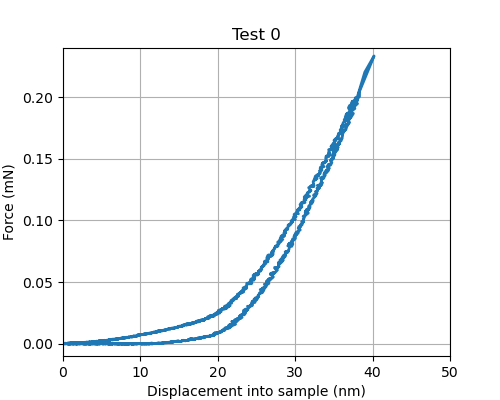

In [15]:
#Draw sample displacement

scan_number=0

scan=scan_number
fig = plt.figure(figsize=(5, 4),facecolor=None)
axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*SampleDisplacement[scan]).max()+10,0)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]).min()-0.01,2),round(np.array(0.001*ForceA[scan]).max()+0.01,2)])
#plt.title("Test "+str(scan))
#plt.xlim([0,round(np.array(1000*SampleDisplacement[scan]).max()+1,0)])
plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan])
plt.title("Test "+str(scan))
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')
#plt.axis('tight')
#plt.tight_layout()
plt.savefig('Test_'+str(scan)+'.png')
plt.show()


In [16]:
#PILLAR1 - SAMPLE 4

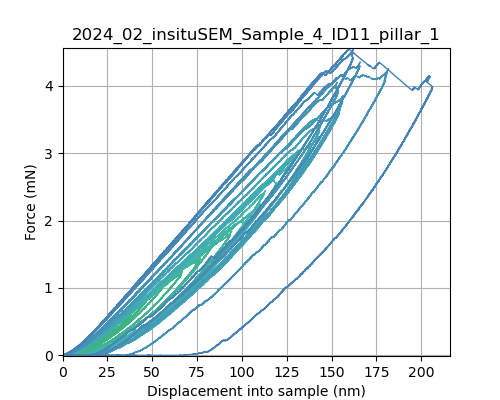

In [38]:
#Test compression sample4 pillar1


Name='2024_02_insituSEM_Sample_4_ID11_pillar_1'
height=3 #microns
top_diameter=1 #microns
middle_diameter=1 #microns
base_diameter=1 #microns

plt.figure(figsize=(5, 4),facecolor=None)


Liste_selected_tests=[44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,67,68]

nbre_tests=len(Liste_selected_tests)



scan=Liste_selected_tests[nbre_tests-1]

axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*SampleDisplacement[scan]).max()+10,0)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]).min()-0.01,2),round(np.array(0.001*ForceA[scan]).max()+0.01,2)])
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan],c=colors[i].hex,linewidth=1)

plt.savefig('LoadVSDispOntoSample_'+Name+'.png')
plt.show()





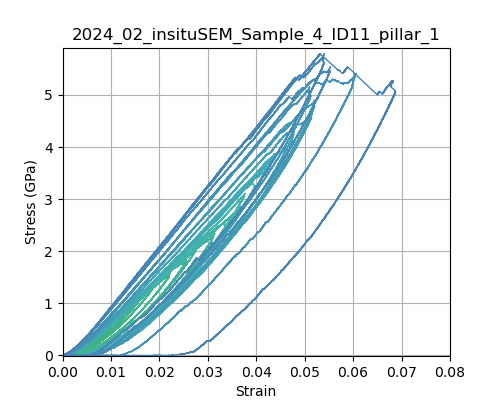

In [39]:
plt.figure(figsize=(5, 4),facecolor=None)


scan=Liste_selected_tests[nbre_tests-1]

axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*SampleDisplacement[scan]/(height*1000)).max()+0.01,2)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)).min()-0.01,2),round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)+0.1).max()+0.01,2)])
plt.title(Name)
plt.xlabel('Strain')
plt.ylabel('Stress (GPa)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    plt.plot(1000*SampleDisplacement[scan]/(height*1000),0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2),c=colors[i].hex,linewidth=1)

plt.savefig('StressVSStrain_'+Name+'.png')
plt.show()

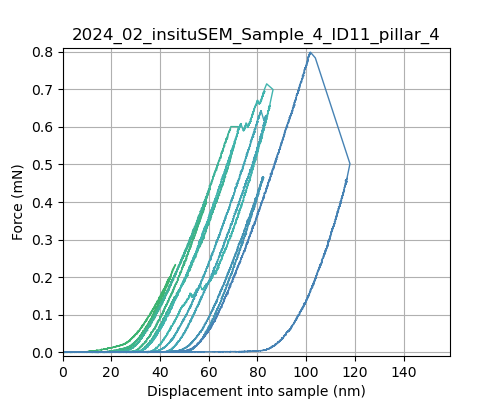

In [59]:




plt.figure(figsize=(5, 4),facecolor=None)



#recalage par rapport à la surface du premier test
scan=Liste_selected_tests[0]
Surface_position_first_test=Displacement_raw[scan][0]-SampleDisplacement[scan][0]
PosX_first_test=Pos_X[scan][0]

#gestion des bornes des axes
scan=Liste_selected_tests[nbre_tests-1]
axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*(Displacement[scan]-Surface_position_first_test)).max()+10,0)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]).min()-0.01,2),round(np.array(0.001*ForceA[scan]).max()+0.01,2)])

#Nom des axes
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')

#Gestion des couleurs
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))



#Tracer

for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    derive_X=derive_X=(Pos_X[scan][0]-PosX_first_test)
    plt.plot(1000*(Displacement[scan]-Surface_position_first_test+derive_X),0.001*ForceA[scan],c=colors[i].hex,linewidth=1)

plt.savefig('LoadVSDisp_'+Name+'.png')
plt.show()


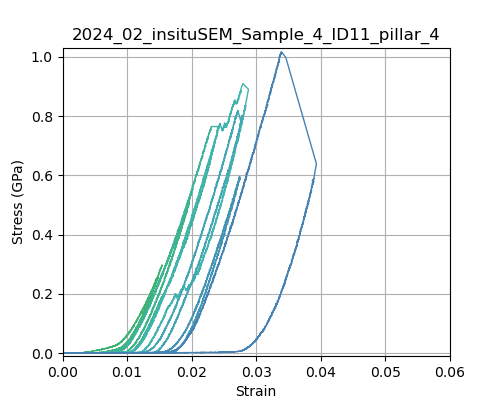

In [60]:
plt.figure(figsize=(5, 4),facecolor=None)


scan=Liste_selected_tests[nbre_tests-1]

axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*(Displacement[scan]/(height*1000)-Surface_position_first_test/(height*1000))).max()+0.01,2)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)).min()-0.01,2),round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)).max()+0.01,2)])
plt.title(Name)
plt.xlabel('Strain')
plt.ylabel('Stress (GPa)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    derive_X=derive_X=(Pos_X[scan][0]-PosX_first_test)
    plt.plot(1000*(Displacement[scan]/(height*1000)-Surface_position_first_test/(height*1000)+derive_X/(height*1000)),0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2),c=colors[i].hex,linewidth=1)

plt.savefig('StressVSStrain2_'+Name+'.png')
plt.show()


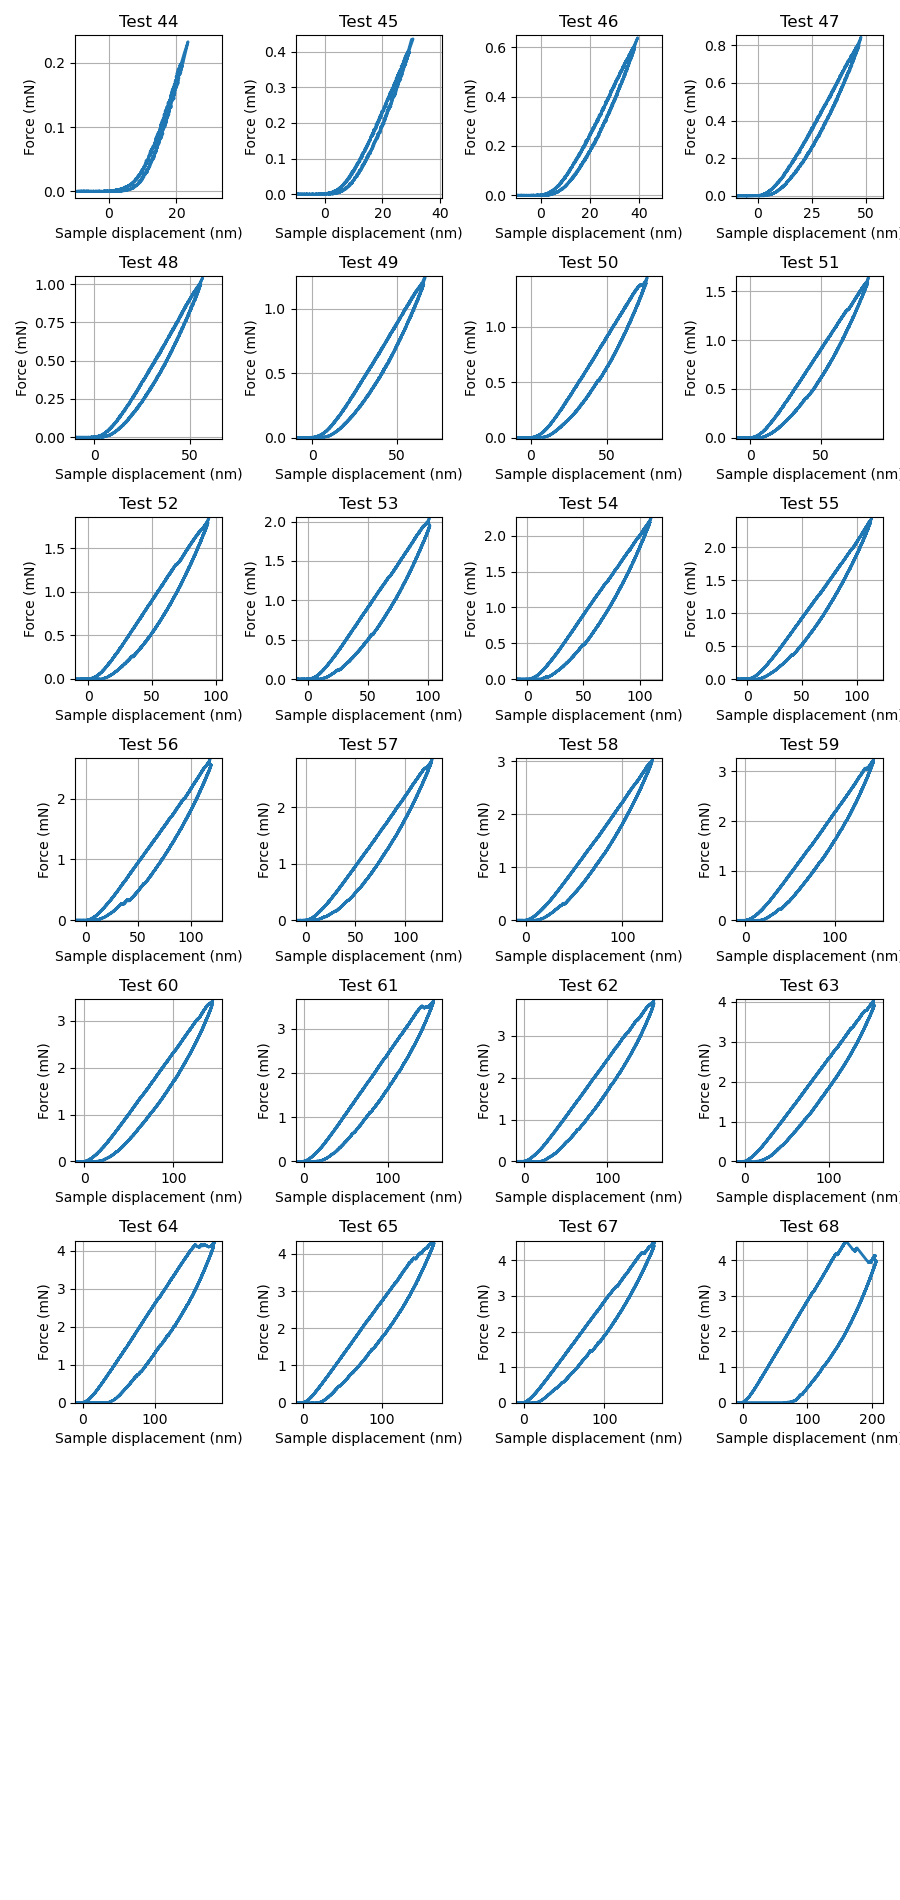

In [41]:
#Draw all sample displacement


plt.figure(figsize=(9,19))

for i in range(nbre_tests):#wanted_test:
    scan=Liste_selected_tests[i]
    plt.subplot(nbre_tests//3,4,i+1)
    plt.title("Test "+str(scan))
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan])
    if len(SampleDisplacement[scan])>0:
        plt.xlim(-10,np.array(1000*SampleDisplacement[scan]).max()+10)
        plt.ylim(-0.01,np.array(0.001*ForceA[scan]).max()+0.01)
    plt.xlabel('Sample displacement (nm)')
    plt.ylabel('Force (mN)')
    #plt.axis('tight')
    i+=1
plt.tight_layout()
plt.savefig('All_'+Name+'.png')
plt.show()

In [42]:
#PILLAR2 - SAMPLE 1

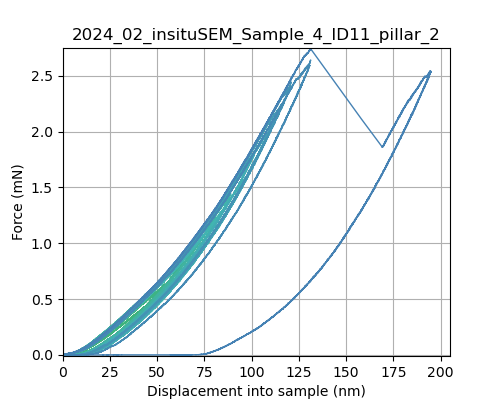

In [43]:
#Test compression sample4 pillar2


Name='2024_02_insituSEM_Sample_4_ID11_pillar_2'

plt.figure(figsize=(5, 4),facecolor=None)


Liste_selected_tests=[29,30,31,32,33,34,35,36,37,38,39,40,41,42]

nbre_tests=len(Liste_selected_tests)



scan=Liste_selected_tests[nbre_tests-1]
axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*SampleDisplacement[scan]).max()+10,0)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]).min()-0.01,2),round(np.array(0.001*ForceA[scan]).max()+0.01,2)])
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan],c=colors[i].hex,linewidth=1)

plt.savefig('LoadVSDispOntoSample_'+Name+'.png')
plt.show()

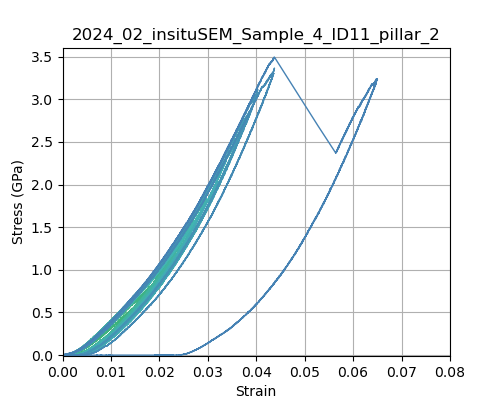

In [44]:
plt.figure(figsize=(5, 4),facecolor=None)


scan=Liste_selected_tests[nbre_tests-1]

axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*SampleDisplacement[scan]/(height*1000)).max()+0.01,2)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)).min()-0.01,2),round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)+0.1).max()+0.01,2)])
plt.title(Name)
plt.xlabel('Strain')
plt.ylabel('Stress (GPa)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    plt.plot(1000*SampleDisplacement[scan]/(height*1000),0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2),c=colors[i].hex,linewidth=1)

plt.savefig('StressVSStrain_'+Name+'.png')
plt.show()

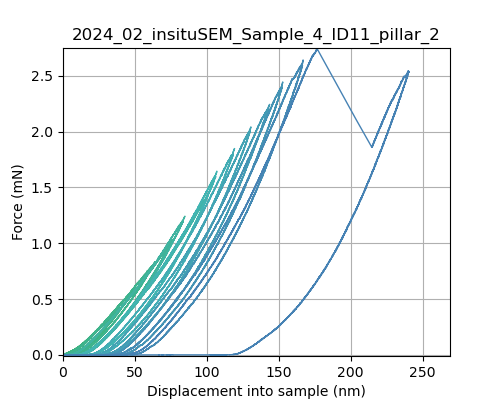

In [45]:




plt.figure(figsize=(5, 4),facecolor=None)


#recalage par rapport à la surface du premier test
scan=Liste_selected_tests[0]
Surface_position_first_test=Displacement_raw[scan][0]-SampleDisplacement[scan][0]
PosX_first_test=Pos_X[scan][0]

#gestion des bornes des axes
scan=Liste_selected_tests[nbre_tests-1]
axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*(Displacement[scan]-Surface_position_first_test)).max()+10,0)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]).min()-0.01,2),round(np.array(0.001*ForceA[scan]).max()+0.01,2)])

#Nom des axes
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')

#Gestion des couleurs
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))



#Tracer

for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    derive_X=derive_X=(Pos_X[scan][0]-PosX_first_test)
    plt.plot(1000*(Displacement[scan]-Surface_position_first_test+derive_X),0.001*ForceA[scan],c=colors[i].hex,linewidth=1)

plt.savefig('LoadVSDisp_'+Name+'.png')
plt.show()


In [ ]:
plt.figure(figsize=(5, 4),facecolor=None)


scan=Liste_selected_tests[nbre_tests-1]

axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*(Displacement[scan]/(height*1000)-Surface_position_first_test/(height*1000))).max()+0.01,2)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)).min()-0.01,2),round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)).max()+0.01,2)])
plt.title(Name)
plt.xlabel('Strain')
plt.ylabel('Stress (GPa)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    derive_X=derive_X=(Pos_X[scan][0]-PosX_first_test)
    plt.plot(1000*(Displacement[scan]/(height*1000)-Surface_position_first_test/(height*1000)+derive_X/(height*1000)),0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2),c=colors[i].hex,linewidth=1)

plt.savefig('StressVSStrain2_'+Name+'.png')
plt.show()

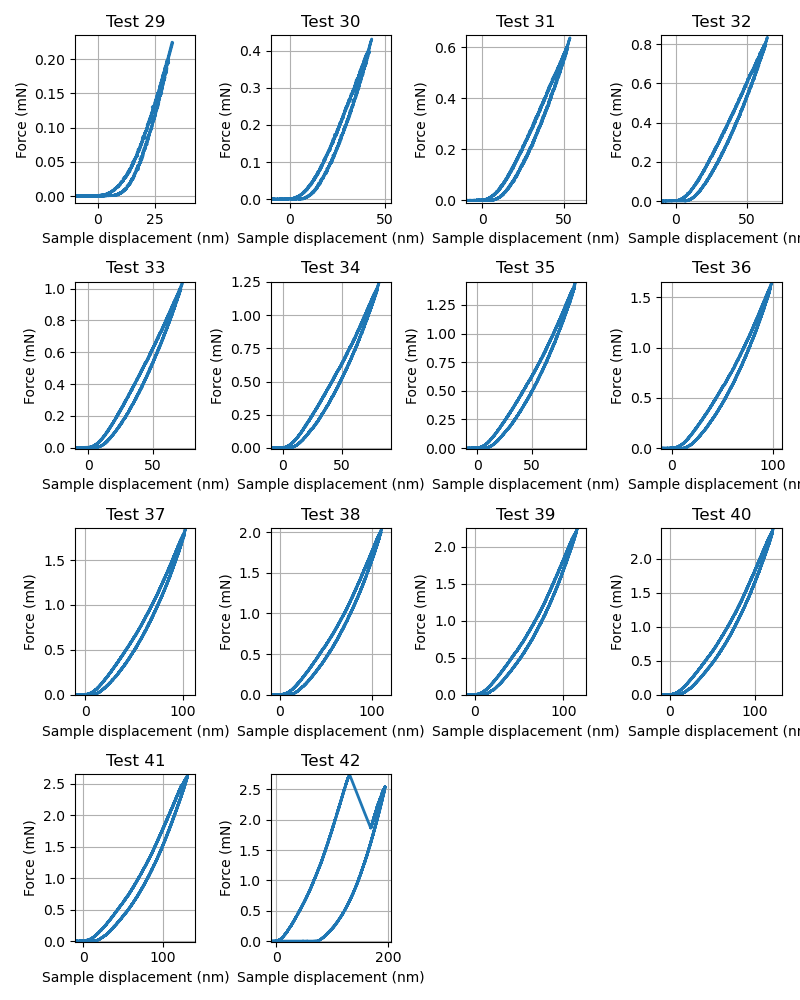

In [46]:
#Draw all sample displacement


plt.figure(figsize=(8,10))

for i in range(nbre_tests):#wanted_test:
    scan=Liste_selected_tests[i]
    plt.subplot(nbre_tests//3,4,i+1)
    plt.title("Test "+str(scan))
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan])
    if len(SampleDisplacement[scan])>0:
        plt.xlim(-10,np.array(1000*SampleDisplacement[scan]).max()+10)
        plt.ylim(-0.01,np.array(0.001*ForceA[scan]).max()+0.01)
    plt.xlabel('Sample displacement (nm)')
    plt.ylabel('Force (mN)')
    #plt.axis('tight')
    i+=1
plt.tight_layout()
plt.savefig('All_'+Name+'.png')
plt.show()

In [47]:
#PILLAR3 - SAMPLE 4

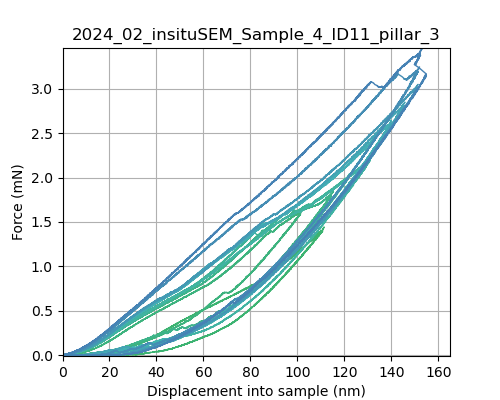

In [48]:
#Test compression sample4 pillar3


Name='2024_02_insituSEM_Sample_4_ID11_pillar_3'

plt.figure(figsize=(5, 4),facecolor=None)


Liste_selected_tests=[18,19,20,21,22,23,24,25,26,27,28]

nbre_tests=len(Liste_selected_tests)



scan=Liste_selected_tests[nbre_tests-1]
axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*SampleDisplacement[scan]).max()+10,0)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]).min()-0.01,2),round(np.array(0.001*ForceA[scan]).max()+0.01,2)])
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan],c=colors[i].hex,linewidth=1)

plt.savefig('LoadVSDispOntoSample_'+Name+'.png')
plt.show()

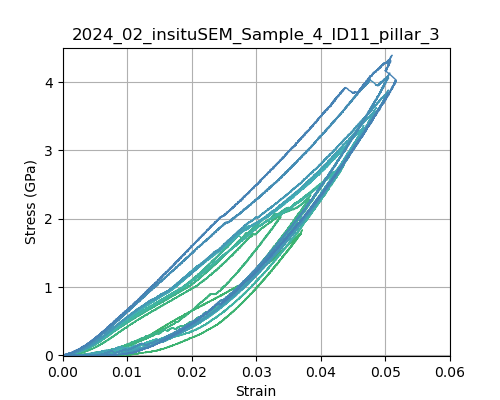

In [49]:
plt.figure(figsize=(5, 4),facecolor=None)


scan=Liste_selected_tests[nbre_tests-1]

axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*SampleDisplacement[scan]/(height*1000)).max()+0.01,2)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)).min()-0.01,2),round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)+0.1).max()+0.01,2)])
plt.title(Name)
plt.xlabel('Strain')
plt.ylabel('Stress (GPa)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    plt.plot(1000*SampleDisplacement[scan]/(height*1000),0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2),c=colors[i].hex,linewidth=1)

plt.savefig('StressVSStrain_'+Name+'.png')
plt.show()

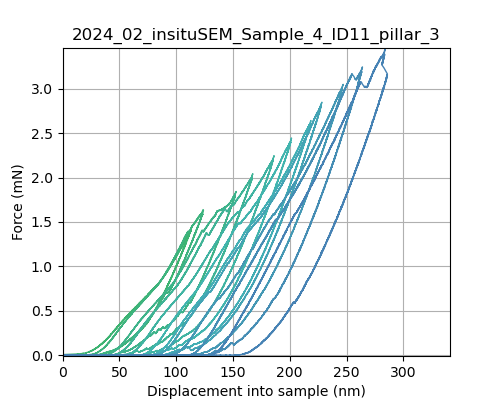

In [50]:


plt.figure(figsize=(5, 4),facecolor=None)


#recalage par rapport à la surface du premier test
scan=Liste_selected_tests[0]
Surface_position_first_test=Displacement_raw[scan][0]-SampleDisplacement[scan][0]
PosX_first_test=Pos_X[scan][0]

#gestion des bornes des axes
scan=Liste_selected_tests[nbre_tests-1]
axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*(Displacement[scan]-Surface_position_first_test)).max()+10,0)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]).min()-0.01,2),round(np.array(0.001*ForceA[scan]).max()+0.01,2)])

#Nom des axes
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')

#Gestion des couleurs
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))



#Tracer

for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    derive_X=derive_X=(Pos_X[scan][0]-PosX_first_test)
    plt.plot(1000*(Displacement[scan]-Surface_position_first_test+derive_X),0.001*ForceA[scan],c=colors[i].hex,linewidth=1)

plt.savefig('LoadVSDisp_'+Name+'.png')
plt.show()


In [ ]:
plt.figure(figsize=(5, 4),facecolor=None)


scan=Liste_selected_tests[nbre_tests-1]

axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*(Displacement[scan]/(height*1000)-Surface_position_first_test/(height*1000))).max()+0.01,2)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)).min()-0.01,2),round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)).max()+0.01,2)])
plt.title(Name)
plt.xlabel('Strain')
plt.ylabel('Stress (GPa)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    derive_X=derive_X=(Pos_X[scan][0]-PosX_first_test)
    plt.plot(1000*(Displacement[scan]/(height*1000)-Surface_position_first_test/(height*1000)+derive_X/(height*1000)),0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2),c=colors[i].hex,linewidth=1)

plt.savefig('StressVSStrain2_'+Name+'.png')
plt.show()

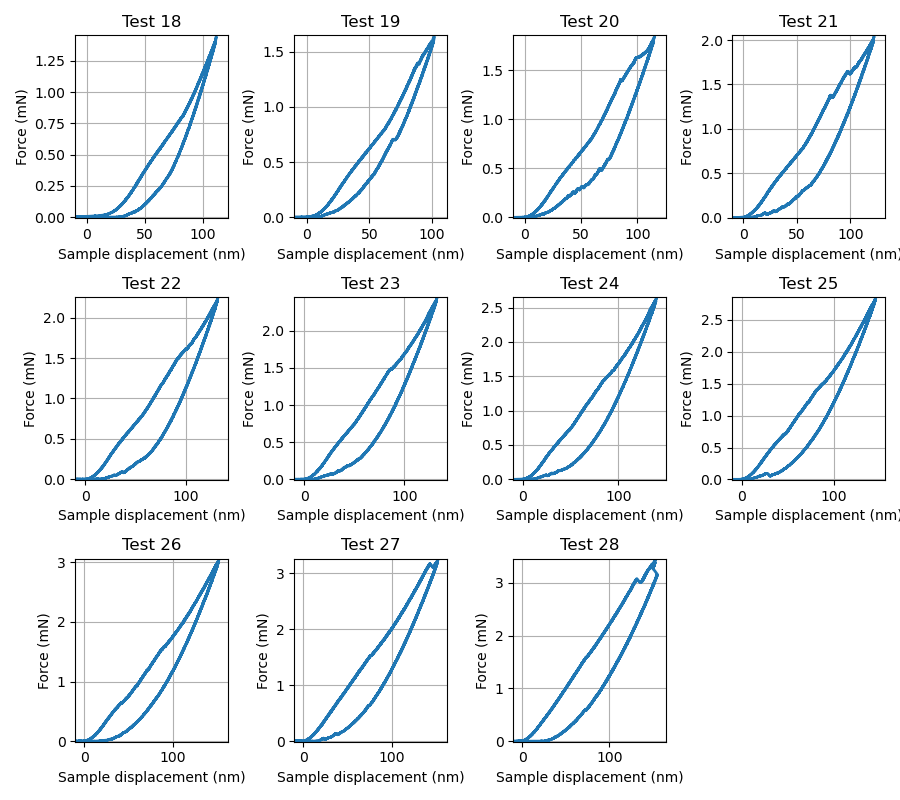

In [51]:
#Draw all sample displacement


plt.figure(figsize=(9,8))

for i in range(nbre_tests):#wanted_test:
    scan=Liste_selected_tests[i]
    plt.subplot(nbre_tests//3,4,i+1)
    plt.title("Test "+str(scan))
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan])
    if len(SampleDisplacement[scan])>0:
        plt.xlim(-10,np.array(1000*SampleDisplacement[scan]).max()+10)
        plt.ylim(-0.01,np.array(0.001*ForceA[scan]).max()+0.01)
    plt.xlabel('Sample displacement (nm)')
    plt.ylabel('Force (mN)')
    #plt.axis('tight')
    i+=1
plt.tight_layout()
plt.savefig('All_'+Name+'.png')
plt.show()

In [52]:
#PILLAR4 SAMPLE4

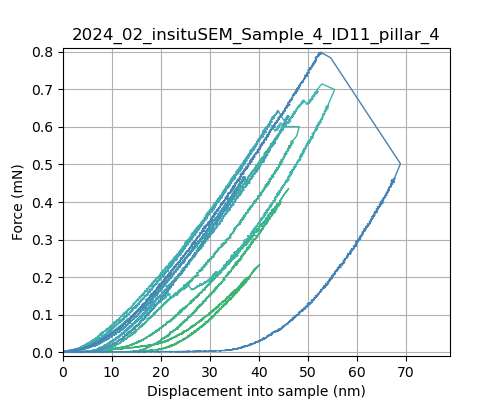

In [53]:
#Test compression sample4 pillar4


Name='2024_02_insituSEM_Sample_4_ID11_pillar_4'

plt.figure(figsize=(5, 4),facecolor=None)


Liste_selected_tests=[0,1,2,3,4,5,6]

nbre_tests=len(Liste_selected_tests)



scan=Liste_selected_tests[nbre_tests-1]
axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*SampleDisplacement[scan]).max()+10,0)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]).min()-0.01,2),round(np.array(0.001*ForceA[scan]).max()+0.01,2)])
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan],c=colors[i].hex,linewidth=1)

plt.savefig('LoadVSDispOntoSample_'+Name+'.png')
plt.show()

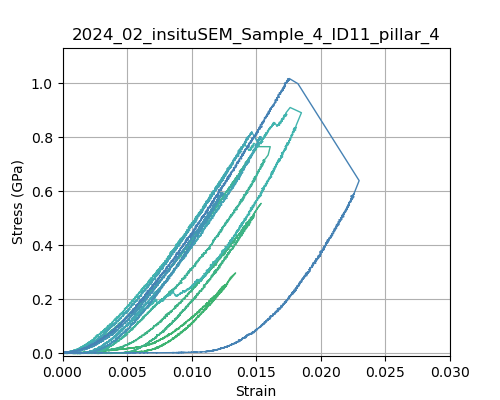

In [54]:
plt.figure(figsize=(5, 4),facecolor=None)


scan=Liste_selected_tests[nbre_tests-1]

axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*SampleDisplacement[scan]/(height*1000)).max()+0.01,2)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)).min()-0.01,2),round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)+0.1).max()+0.01,2)])
plt.title(Name)
plt.xlabel('Strain')
plt.ylabel('Stress (GPa)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    plt.plot(1000*SampleDisplacement[scan]/(height*1000),0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2),c=colors[i].hex,linewidth=1)

plt.savefig('StressVSStrain_'+Name+'.png')
plt.show()

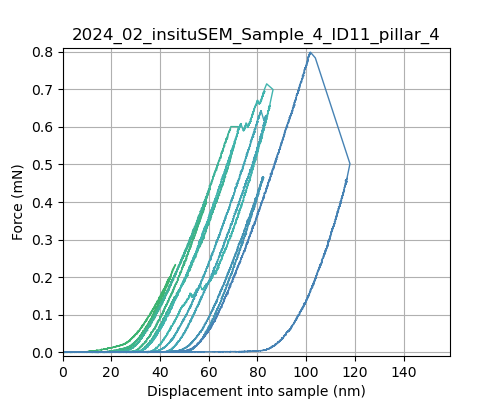

In [55]:


plt.figure(figsize=(5, 4),facecolor=None)


#recalage par rapport à la surface du premier test
scan=Liste_selected_tests[0]
Surface_position_first_test=Displacement_raw[scan][0]-SampleDisplacement[scan][0]
PosX_first_test=Pos_X[scan][0]

#gestion des bornes des axes
scan=Liste_selected_tests[nbre_tests-1]
axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*(Displacement[scan]-Surface_position_first_test)).max()+10,0)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]).min()-0.01,2),round(np.array(0.001*ForceA[scan]).max()+0.01,2)])

#Nom des axes
plt.title(Name)
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')

#Gestion des couleurs
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))



#Tracer

for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    derive_X=derive_X=(Pos_X[scan][0]-PosX_first_test)
    plt.plot(1000*(Displacement[scan]-Surface_position_first_test+derive_X),0.001*ForceA[scan],c=colors[i].hex,linewidth=1)

plt.savefig('LoadVSDisp_'+Name+'.png')
plt.show()

In [ ]:
plt.figure(figsize=(5, 4),facecolor=None)


scan=Liste_selected_tests[nbre_tests-1]

axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*(Displacement[scan]/(height*1000)-Surface_position_first_test/(height*1000))).max()+0.01,2)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)).min()-0.01,2),round(np.array(0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2)).max()+0.01,2)])
plt.title(Name)
plt.xlabel('Strain')
plt.ylabel('Stress (GPa)')
color1 = Color("mediumseagreen") #cornflowerblue")#Color("navy")
color2=Color("steelblue")
colors = list(color1.range_to(color2,nbre_tests))


#viridis = mpl.colormaps['viridis'].resampled(8)
#coloration=viridis(range(nbre_tests))


for i in range (nbre_tests):
    scan=Liste_selected_tests[i]
    derive_X=derive_X=(Pos_X[scan][0]-PosX_first_test)
    plt.plot(1000*(Displacement[scan]/(height*1000)-Surface_position_first_test/(height*1000)+derive_X/(height*1000)),0.001*ForceA[scan]/(np.pi*(middle_diameter/2)**2),c=colors[i].hex,linewidth=1)

plt.savefig('StressVSStrain2_'+Name+'.png')
plt.show()

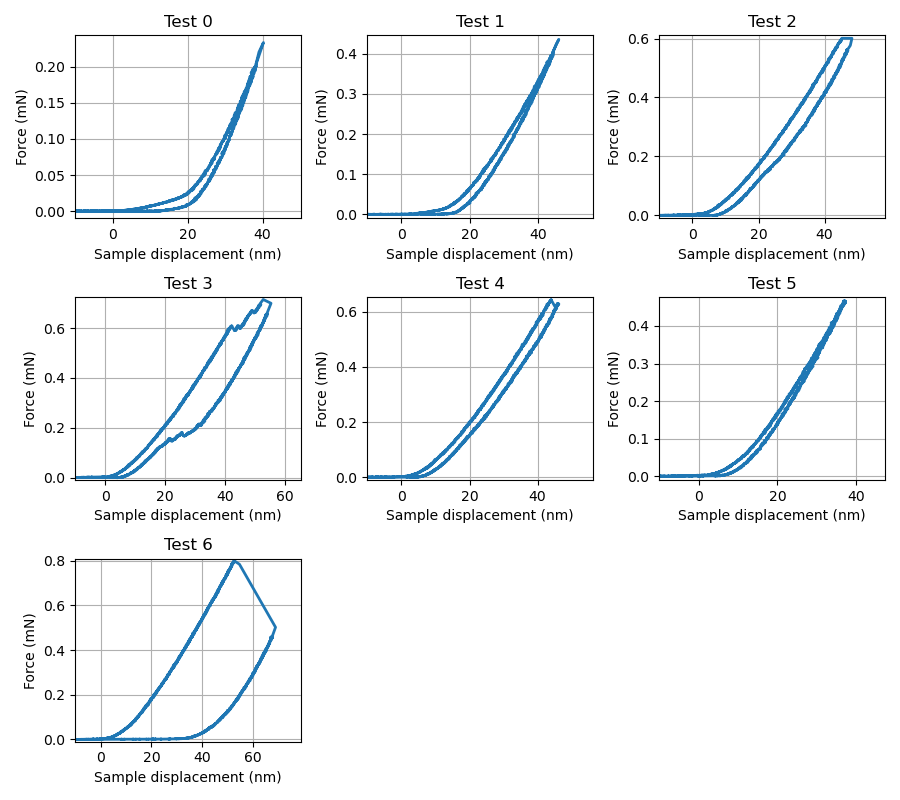

In [56]:
#Draw all sample displacement


plt.figure(figsize=(9,8))

for i in range(nbre_tests):#wanted_test:
    scan=Liste_selected_tests[i]
    plt.subplot(nbre_tests//2,3,i+1)
    plt.title("Test "+str(scan))
    plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan])
    if len(SampleDisplacement[scan])>0:
        plt.xlim(-10,np.array(1000*SampleDisplacement[scan]).max()+10)
        plt.ylim(-0.01,np.array(0.001*ForceA[scan]).max()+0.01)
    plt.xlabel('Sample displacement (nm)')
    plt.ylabel('Force (mN)')
    #plt.axis('tight')
    i+=1
plt.tight_layout()
plt.savefig('All_'+Name+'.png')
plt.show()

In [57]:
#TEST!


def on_click(event):
    pressed = ax.button_pressed
    ax.button_pressed = -1 # some value that doesn't make sense.
    coords = ax.format_coord(event.xdata, event.ydata) # coordinates string in the form x=value, y=value, z= value
    ax.button_pressed = pressed
    return coords

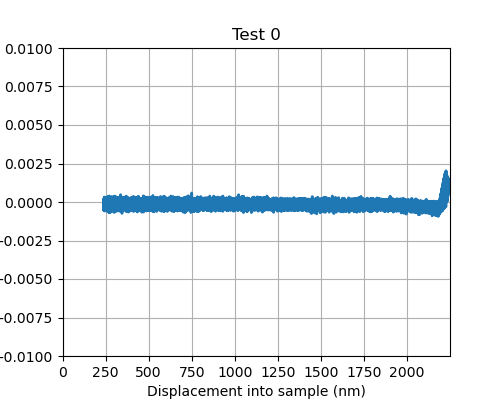

In [69]:
#Recalage surface
scan_number=0

scan=scan_number
fig = plt.figure(figsize=(5, 4),facecolor=None)
axes = plt.axes()
axes.set_xlim([0,round(np.array(1000*SampleDisplacement[scan]).max()+10,0)])
axes.set_ylim([round(np.array(0.001*ForceA[scan]).min()-0.01,2),round(np.array(0.001*ForceA[scan]).max()+0.01,2)])
plt.title("Test "+str(scan))
plt.xlabel('Displacement into sample (nm)')
plt.ylabel('Force (mN)')
plt.plot(1000*SampleDisplacement[scan],0.001*ForceA[scan],picker=3)

#display(fig, output)

def on_click():
        pressed = ax.button_pressed
        ax.button_pressed = -1 # some value that doesn't make sense.
        coords = ax.format_coord(event.xdata, event.ydata) # coordinates string in the form x=value, y=value, z= value
        ax.button_pressed = pressed
        print(coords)

cid=fig.canvas.mpl_connect('button_press_event', on_click)


plt.show()







In [66]:
on_click()

In [67]:
from IPython.display import display
button = widgets.Button(description="Click Me!")
output = widgets.Output()

display(button, output)
v=0

def on_button_clicked(b):
    with output:
        print("Button clicked.")
        return 3

button.on_click(on_button_clicked)


Button(description='Click Me!', style=ButtonStyle())

Output()

In [52]:
on_button_clicked(b)

3

In [ ]:

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()


x = np.linspace(0, 2*np.pi, 100)
y = np.sin(3*x)
ax.plot(x, y)



In [ ]:
scan_old=0
plt.figure(figsize=(15,10),layout='tight')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
i,ii_lab=0,0
for scan in (wanted_test):
    if  ForceA[scan].max()<2:
        continue
    #cut_disp=Displacement[scan][np.where((ForceA[scan]<10) & (ForceA[scan]>8))[0][0]]
    
    cut_disp=0.85*Displacement[scan].max()
    if Displacement[scan].max()>1:
        cut_disp=0.5
        
    plt.subplot(4,4,i+1)
    plt.plot(Displacement[scan],ForceA[scan],".",label='raw')
    plt.plot(Displacement_cal[scan],ForceA[scan],".",label='calibrated')

        
    a=ForceA[scan]
    b=np.array(ForceA[scan])
    b[0:-1]=a[1:]
    diff=a-b
    diff[np.where(np.abs(a-b)<2)]=0
    minnn=Displacement[scan][np.where(np.abs(a-b)>1.5)].min()-0.02
    plt.xlim(minnn,Displacement[scan].max()+0.05)
    plt.ylim(0,ForceA[scan].max()+5)
    plt.xlabel('Disp (µm)')
    plt.ylabel('Force (µN)')
    plt.grid(alpha=0.1)
    plt.title("Test "+str(scan-1)+" "+wanted_test_part[ii_lab] )
    #plt.axis('tight')
    if scan not in ( 60, 61, 62,63):
        plt.legend()
        i+=1
    else:
        plt.title("Test "+str(np.array(( 60, 61, 62, 63))-1)+" "+wanted_test_part[ii_lab] )
        
        
    ii_lab+=1
#plt.tight_layout()
plt.savefig('Test_sel_real.png')
plt.show()

In [ ]:
scan

In [ ]:
pwd

In [ ]:
 scan